In [359]:
!pip freeze

aiobotocore==2.12.2
aiohttp==3.9.3
aioitertools==0.11.0
aiosignal==1.3.1
anndata==0.10.7
annotated-types==0.6.0
anyio==4.3.0
appdirs==1.4.4
appnope==0.1.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_api_compat==1.6
arrow==1.3.0
asciitree==0.3.3
asttokens==2.4.1
async-lru==2.0.4
async-timeout==4.0.3
attrs==23.2.0
Babel==2.14.0
backports.tarfile==1.0.0
beautifulsoup4==4.12.3
bidsschematools==0.7.2
biothings-client==0.3.1
bleach==6.1.0
blessed==1.20.0
botocore==1.34.51
certifi==2024.2.2
cffi==1.16.0
charset-normalizer==3.3.2
ci-info==0.3.0
click==8.1.7
click-didyoumean==0.3.1
comm==0.2.2
contourpy==1.2.1
cycler==0.12.1
dandi==0.61.2
dandischema==0.10.1
debugpy==1.8.1
decorator==5.1.1
defusedxml==0.7.1
dnspython==2.6.1
email_validator==2.1.1
etelemetry==0.3.1
exceptiongroup==1.2.0
executing==2.0.1
fasteners==0.19
fastjsonschema==2.19.1
fonttools==4.51.0
fqdn==1.5.1
frozenlist==1.4.1
fscacher==0.4.0
fsspec==2024.3.1
get-annotations==0.1.2
gtfparse @ git+https://github.com/openvax

In [1]:
import pandas as pd
import numpy as np

In [1]:
import pandas as pd
import numpy as np

extended_p_me_t = pd.read_csv("../probabilistic_mapping_extention/extended_p_me_t.csv", index_col=0)

common_t_types = extended_p_me_t.index
msk_t_types = np.asarray([("IMN" not in x) & ("NN" not in x) for x in common_t_types])
common_t_types = common_t_types[msk_t_types]

extended_p_me_t = extended_p_me_t.reindex(common_t_types, axis=0)
extended_p_me_t = extended_p_me_t.div(np.sum(extended_p_me_t, axis=1), axis=0)

np.sum(extended_p_me_t,axis=1)

0042_L6_IT_CTX_Glut_2        1.0
0049_L6_IT_CTX_Glut_4        1.0
0063_L5_IT_CTX_Glut_4        1.0
0247_LA-BLA-BMA-PA_Glut_5    1.0
0288_CA1-ProS_Glut_4         1.0
                            ... 
5201_CB_Granule_Glut_2       1.0
5202_DCO_UBC_Glut_1          1.0
5203_DCO_UBC_Glut_1          1.0
5204_DCO_UBC_Glut_1          1.0
5205_DCO_UBC_Glut_1          1.0
Length: 5168, dtype: float64

In [2]:
# mt_labels = pd.read_csv("../probabilistic_mapping_extention/t_and_m_types.csv", index_col=0)

# dict_mclass = {0.0: "PC", 1.0: "IN"}
# dict_dendclass = {x: "dend_" + str(int(x)) for x in np.unique(mt_labels["dendrites"])}
# dict_axclass = {x: "ax_" + str(int(x)) for x in np.unique(mt_labels["axon"])}
# dict_mlabels = {"class": dict_mclass, "dendrites": dict_dendclass, "axon": dict_axclass}

# m_labels = ["_".join([dict_mlabels["class"][mt_labels["class"][x]],
#                       dict_mlabels["dendrites"][mt_labels["dendrites"][x]],
#                       dict_mlabels["axon"][mt_labels["axon"][x]]
#                       ]) for x in mt_labels.index]
# t_labels = mt_labels["AIBS lvl 0"]

In [3]:
neur_list = ["IN_", "PC_"]
dend_list = [f"dend_{x}_" for x in range(10)]
ax_list = [f"ax_{x}" for x in range(10)]

m_types_list = []

for neur in neur_list:
    for dend in dend_list:
        for ax in ax_list:
            m_types_list.append(neur+dend+ax)

pd.DataFrame(m_types_list, columns=["canonical m-type"]).to_csv("/Users/yroussel/Documents/projects/probabilistic_mapping_wholebrain/lida_m_types/m_types_list.csv")

In [4]:
import mygene

def convert_gene_tags_to_labels(dataframe):
    """
    Convert gene tags to gene labels using MyGeneInfo API.

    :param dataframe: Pandas DataFrame containing gene tags as column names.
    :return: Pandas DataFrame with gene labels replacing gene tags.
    """
    mg = mygene.MyGeneInfo()
    ens = dataframe.columns.to_list()
    ginfo = mg.querymany(ens, scopes='ensembl.gene')

    dict_id_to_symbol = {}

    for g in ginfo:
        try:
            dict_id_to_symbol[g["query"]] = g["symbol"]
        except:
            dict_id_to_symbol[g["query"]] = g["query"]

    return dataframe.rename(dict_id_to_symbol, axis=1)
    
yao = pd.read_csv("../experimental_data/yao/all_clusters_trim_mean25_g32285ct5322.csv", index_col="gene_identifier").T
# yao = convert_gene_tags_to_labels(yao)

In [5]:
# df = pd.concat([yao.T[t_labels].T,
#                 pd.DataFrame(m_labels, index=t_labels, columns=["m_type"])],
#                axis=1)
# df.head()       

In [6]:
# mean_df = df.groupby("m_type").mean()
# std_df = df.groupby("m_type").std()
# sum_df = df.groupby("m_type").sum()

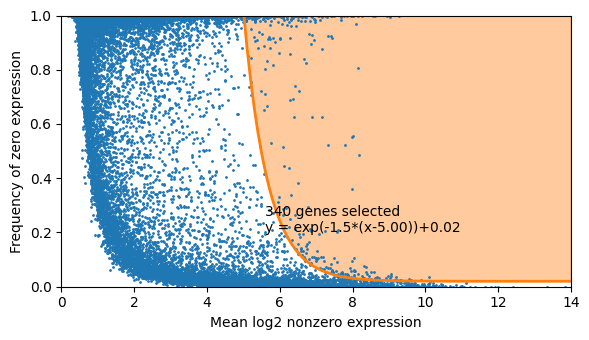

In [7]:
from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt

def geneSelection(data, threshold=0, atleast=10, 
                  yoffset=.02, xoffset=5, decay=1.5, n=None, 
                  plot=True, markers=None, genes=None, figsize=(6,3.5),
                  markeroffsets=None, labelsize=10, alpha=1, verbose=1):
    
    if sparse.issparse(data):
        zeroRate = 1 - np.squeeze(np.array((data>threshold).mean(axis=0)))
        A = data.multiply(data>threshold)
        # A.data = np.log2(A.data)
        A.data = A.data
        meanExpr = np.zeros_like(zeroRate) * np.nan
        detected = zeroRate < 1
        meanExpr[detected] = np.squeeze(np.array(A[:,detected].mean(axis=0))) / (1-zeroRate[detected])
    else:
        zeroRate = 1 - np.mean(data>threshold, axis=0)
        meanExpr = np.zeros_like(zeroRate) * np.nan
        detected = zeroRate < 1
        mask = data[:,detected]>threshold
        logs = np.zeros_like(data[:,detected]) * np.nan
        # logs[mask] = np.log2(data[:,detected][mask])
        logs[mask] = data[:,detected][mask]
        meanExpr[detected] = np.nanmean(logs, axis=0)

    lowDetection = np.array(np.sum(data>threshold, axis=0)).squeeze() < atleast
    zeroRate[lowDetection] = np.nan
    meanExpr[lowDetection] = np.nan
            
    if n is not None:
        up = 10
        low = 0
        for t in range(100):
            nonan = ~np.isnan(zeroRate)
            selected = np.zeros_like(zeroRate).astype(bool)
            selected[nonan] = zeroRate[nonan] > np.exp(-decay*(meanExpr[nonan] - xoffset)) + yoffset
            if np.sum(selected) == n:
                break
            elif np.sum(selected) < n:
                up = xoffset
                xoffset = (xoffset + low)/2
            else:
                low = xoffset
                xoffset = (xoffset + up)/2
        if verbose>0:
            print('Chosen offset: {:.2f}'.format(xoffset))
    else:
        nonan = ~np.isnan(zeroRate)
        selected = np.zeros_like(zeroRate).astype(bool)
        selected[nonan] = zeroRate[nonan] > np.exp(-decay*(meanExpr[nonan] - xoffset)) + yoffset
                
    if plot:
        if figsize is not None:
            plt.figure(figsize=figsize)
        plt.ylim([0, 1])
        if threshold>0:
            plt.xlim([np.log2(threshold), np.ceil(np.nanmax(meanExpr))])
            # plt.xlim([threshold, np.ceil(np.nanmax(meanExpr))])
        else:
            plt.xlim([0, np.ceil(np.nanmax(meanExpr))])
        x = np.arange(plt.xlim()[0], plt.xlim()[1]+.1,.1)
        y = np.exp(-decay*(x - xoffset)) + yoffset
        if decay==1:
            plt.text(.4, 0.2, '{} genes selected\ny = exp(-x+{:.2f})+{:.2f}'.format(np.sum(selected),xoffset, yoffset), 
                     color='k', fontsize=labelsize, transform=plt.gca().transAxes)
        else:
            plt.text(.4, 0.2, '{} genes selected\ny = exp(-{:.1f}*(x-{:.2f}))+{:.2f}'.format(np.sum(selected),decay,xoffset, yoffset), 
                     color='k', fontsize=labelsize, transform=plt.gca().transAxes)

        plt.plot(x, y, color=sns.color_palette()[1], linewidth=2)
        xy = np.concatenate((np.concatenate((x[:,None],y[:,None]),axis=1), np.array([[plt.xlim()[1], 1]])))
        t = plt.matplotlib.patches.Polygon(xy, color=sns.color_palette()[1], alpha=.4)
        plt.gca().add_patch(t)
        
        plt.scatter(meanExpr, zeroRate, s=1, alpha=alpha, rasterized=True)
        if threshold==0:
            plt.xlabel('Mean log2 nonzero expression')
            plt.ylabel('Frequency of zero expression')
        else:
            plt.xlabel('Mean log2 nonzero expression')
            plt.ylabel('Frequency of near-zero expression')
        plt.tight_layout()
        
        if markers is not None and genes is not None:
            if markeroffsets is None:
                markeroffsets = [(0, 0) for g in markers]
            for num,g in enumerate(markers):
                i = np.where(genes==g)[0]
                plt.scatter(meanExpr[i], zeroRate[i], s=10, color='k')
                dx, dy = markeroffsets[num]
                plt.text(meanExpr[i]+dx+.1, zeroRate[i]+dy, g, color='k', fontsize=labelsize)
    
    return selected


selected_genes_level0 = geneSelection(yao.values, threshold=0, atleast=10, 
                  yoffset=.02, xoffset=5, decay=1.5)

selected_genes_level0 = yao.columns[selected_genes_level0]

In [8]:
# x = std_df[selected_genes_level0].mean(axis=0)
# y = std_df[selected_genes_level0].std(axis=0)

# plt.plot(x, y, "o")

# selected_genes_level1 = (x < 2) & (y > 1.5)
# plt.plot(x[selected_genes_level1], y[selected_genes_level1], "o")

# selected_genes_level1 = selected_genes_level0[selected_genes_level1]

# plt.xlabel('in m-type gene variability (std)')
# plt.ylabel('cross m-type gene variability (std)')
# plt.show()

In [9]:
# m_type_gene_expression = convert_gene_tags_to_labels(mean_df[selected_genes_level1])
# m_type_gene_expression.to_csv('./m_type_gene_expression.csv')

In [10]:
# m_type_gene_expression.head(3)

In [11]:
# m_type_gene_expression_sum = convert_gene_tags_to_labels(sum_df[selected_genes_level1])
# m_type_gene_expression_sum.to_csv('./m_type_gene_expression_sum.csv')

In [12]:
# t_type_gene_expression = convert_gene_tags_to_labels(df[selected_genes_level1].drop_duplicates())
# t_type_gene_expression.to_csv('./t_type_gene_expression.csv')

In [13]:
# t_type_gene_expression = t_type_gene_expression.rename({x : "_".join(x.split(" ")) for x in t_type_gene_expression.index}, axis=0)

In [8]:
file = './Brain_regions_me_types_composition.csv'
me_types_densities = pd.read_csv(file, index_col=0, header=[0, 1])


# Sum the columns within each "m-type" group
m_types_densities = me_types_densities.T.groupby(level='m-type').sum().T

me_types_densities.columns = [f"{col[0]}|{col[1]}" for col in me_types_densities.columns]
m_types_densities.head()

m-type,IN_dend_0_ax_0,IN_dend_0_ax_2,IN_dend_0_ax_3,IN_dend_0_ax_4,IN_dend_0_ax_5,IN_dend_0_ax_6,IN_dend_0_ax_8,IN_dend_0_ax_9,IN_dend_1_ax_0,IN_dend_1_ax_1,...,PC_dend_2_ax_7,PC_dend_2_ax_8,PC_dend_3_ax_0,PC_dend_3_ax_4,PC_dend_3_ax_6,PC_dend_3_ax_7,PC_dend_3_ax_8,PC_dend_8_ax_4,PC_dend_8_ax_7,PC_dend_8_ax_8
AId5,3.337673,0.0,289.659393,66.276859,31.232993,66.346422,59.723697,10.013020,15.077666,0.0,...,0.0,0.0,0.0,1.820360,0.0,7196.791505,3.640719,45.508989,0.0,486.946181
AId6a,16.904648,0.0,126.698032,138.054009,30.616816,106.077368,46.747937,50.713945,33.364380,0.0,...,0.0,0.0,0.0,7.252607,0.0,3205.652258,14.505214,1165.888372,0.0,2893.790161
AId6b,13.689276,0.0,38.992723,71.263021,0.000000,72.582707,50.869893,41.067827,137.775147,0.0,...,0.0,0.0,0.0,42.984044,0.0,7113.859348,85.968089,2557.550642,0.0,4964.657128
AIp5,6.583867,0.0,175.810539,58.765108,12.716207,56.584821,36.987390,19.751600,17.631482,0.0,...,0.0,0.0,0.0,1.827767,0.0,5878.098110,3.655534,574.014981,0.0,4951.420329
AIp6a,11.481065,0.0,112.140324,159.470389,4.290940,58.624363,50.223358,34.443196,20.431463,0.0,...,0.0,0.0,0.0,232.712718,0.0,4960.035650,465.425436,18.308009,0.0,4960.707670


In [9]:
import pickle
import pandas as pd

def concatenate_dataframes(dataframes_dict):
    """
    Concatenates a dictionary of DataFrames into a single DataFrame.
    
    Parameters:
    - dataframes_dict (dict): Dictionary where keys are strings and values are DataFrames with a single column named 'density'.
    
    Returns:
    - pd.DataFrame: A single concatenated DataFrame with columns renamed to the keys of the input dictionary.
    """
    # Create an empty list to hold the renamed DataFrames
    renamed_dfs = []
    
    # Iterate over the dictionary
    for key, df in dataframes_dict.items():
        # Rename the 'density' column to the key
        renamed_df = df.rename(columns={'density_mm3': key})
        # Append the renamed DataFrame to the list
        renamed_dfs.append(renamed_df)
    
    # Concatenate all DataFrames along the columns
    concatenated_df = pd.concat(renamed_dfs, axis=1)
    
    return concatenated_df

# Open the pickle file in binary read mode
with open('./scaled_densities_t_types_as_keys.pickle', 'rb') as file:
    # Load the data from the file
    data = pickle.load(file)

# Now you can use the data variable which contains the deserialized object
# print(data)

sorted_data = {k: data[k] for k in sorted(data)}

t_densities_df = concatenate_dataframes(sorted_data)
t_tpes_dict = {x: x.replace(" ", "_") for x in t_densities_df.columns}
t_densities_df = t_densities_df.rename(t_tpes_dict, axis=1)
t_densities_df.head()

,0001_CLA-EPd-CTX_Car3_Glut_1,0002_CLA-EPd-CTX_Car3_Glut_1,0003_CLA-EPd-CTX_Car3_Glut_1,0004_CLA-EPd-CTX_Car3_Glut_1,0005_CLA-EPd-CTX_Car3_Glut_2,0006_IT_EP-CLA_Glut_1,0007_IT_EP-CLA_Glut_1,0008_IT_EP-CLA_Glut_1,0009_IT_EP-CLA_Glut_1,0010_IT_EP-CLA_Glut_1,...,5313_BAM_NN_1,5314_BAM_NN_1,5315_Monocytes_NN_1,5316_DC_NN_1,5317_DC_NN_1,5318_DC_NN_1,5319_B_cells_NN_1,5320_ILC_NN_2,5321_NK_cells_NN_3,5322_T_cells_NN_4
AId5,72.814382,9.101798,291.257529,391.377305,72.814382,9.101798,NaN,NaN,9.101798,NaN,...,NaN,36.248958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.124479
AId6a,1421.510956,643.064480,4298.378367,3976.846127,676.909979,473.836985,118.459246,1150.746964,169.227495,236.918493,...,NaN,67.396799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.698399
AId6b,5415.989595,2407.106486,6920.431149,7823.096081,1805.329865,601.776622,300.888311,6920.431149,601.776622,1805.329865,...,NaN,599.161174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AIp5,230.298620,131.599211,213.848719,NaN,871.844776,148.049113,49.349704,115.149310,NaN,148.049113,...,NaN,65.513627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AIp6a,1420.396383,2319.014504,1043.556527,28.987681,2927.755811,898.618120,5942.474665,869.630439,260.889132,521.778263,...,NaN,173.170169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# t_densities_df.columns
# len(common_ttypes)
# t_densities_df[common_ttypes]
# t_type_gene_expression.T[common_ttypes].T

In [17]:
# common_ttypes = t_type_gene_expression.index.intersection(t_densities_df.columns)

# ish_true = t_densities_df[common_ttypes].fillna(0) @ t_type_gene_expression.T[common_ttypes].T.fillna(0)


In [18]:
# common_mtypes = m_type_gene_expression.index.intersection(m_types_densities.columns)

# ish_pred = m_types_densities[common_mtypes].fillna(0) @ m_type_gene_expression.T[common_mtypes].T.fillna(0)
# ish_pred_sum = m_types_densities[common_mtypes].fillna(0) @ m_type_gene_expression_sum.T[common_mtypes].T.fillna(0)

In [10]:
extended_p_me_t

,IN_DEND_0_AX_0|bAC,IN_DEND_0_AX_3|bAC,IN_DEND_0_AX_4|bAC,IN_DEND_0_AX_5|bAC,IN_DEND_0_AX_6|bAC,IN_DEND_0_AX_8|bAC,IN_DEND_0_AX_9|bAC,IN_DEND_1_AX_0|bAC,IN_DEND_1_AX_2|bAC,IN_DEND_1_AX_3|bAC,...,IN_DEND_6_AX_9|dSTUT,IN_DEND_7_AX_0|dSTUT,IN_DEND_7_AX_2|dSTUT,IN_DEND_7_AX_3|dSTUT,IN_DEND_7_AX_8|dSTUT,IN_DEND_8_AX_8|dSTUT,IN_DEND_9_AX_1|dSTUT,IN_DEND_9_AX_2|dSTUT,IN_DEND_9_AX_5|dSTUT,IN_DEND_9_AX_8|dSTUT
0042_L6_IT_CTX_Glut_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0049_L6_IT_CTX_Glut_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0063_L5_IT_CTX_Glut_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0247_LA-BLA-BMA-PA_Glut_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0288_CA1-ProS_Glut_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5201_CB_Granule_Glut_2,0.000000,0.015232,0.025200,0.000000,0.000000,0.013709,0.000000,0.000000,0.006641,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.002031,0.000000,0.001796,0.0,0.0
5202_DCO_UBC_Glut_1,0.000000,0.012580,0.000000,0.026543,0.013641,0.016312,0.000000,0.005846,0.011693,0.000000,...,0.003927,0.0,0.000000,0.002719,0.000000,0.000000,0.005437,0.000000,0.0,0.0
5203_DCO_UBC_Glut_1,0.000000,0.013086,0.028072,0.027611,0.000000,0.015271,0.000000,0.006081,0.009780,0.000000,...,0.000471,0.0,0.000000,0.002828,0.000000,0.002262,0.005656,0.001000,0.0,0.0
5204_DCO_UBC_Glut_1,0.000000,0.013209,0.000000,0.027869,0.014323,0.017127,0.000000,0.006138,0.012277,0.000000,...,0.004123,0.0,0.000478,0.002855,0.001434,0.000000,0.005709,0.000000,0.0,0.0


In [11]:
yao_df = yao.rename({x : "_".join(x.split(" ")) for x in yao.index}, axis=0)
comon_yaotypes = yao_df.index.intersection(extended_p_me_t.index)
comon_yaotypes = comon_yaotypes[extended_p_me_t.T[comon_yaotypes].fillna(0).sum() > 0]
common_ttypes = comon_yaotypes.intersection(t_densities_df.columns)

ttype_gene_expression = convert_gene_tags_to_labels(yao_df[selected_genes_level0][selected_genes_level0].T[common_ttypes].fillna(0).T)

me_type_gene_expression = ttype_gene_expression.T @ extended_p_me_t.T[common_ttypes].T.fillna(0)
me_type_gene_expression = me_type_gene_expression.T

common_brain_regions = t_densities_df.index.intersection(me_types_densities.index)
me_types_densities = t_densities_df.reindex(common_brain_regions)[common_ttypes].fillna(0) @ extended_p_me_t.T[common_ttypes].T.fillna(0)

# common_metypes = me_type_gene_expression.index.intersection(me_types_densities.columns)



me_types_used = extended_p_me_t.columns[extended_p_me_t.T[comon_yaotypes].fillna(0).sum(axis=1) > 0]
correction = (len(comon_yaotypes) / len(me_types_used))

ish_me = me_types_densities.reindex(common_brain_regions).fillna(0) / correction @ me_type_gene_expression / correction

ish_true = t_densities_df.reindex(common_brain_regions)[common_ttypes].fillna(0) @ ttype_gene_expression


In [12]:
print(len(me_types_used))
print(len(comon_yaotypes))
print((len(me_types_used)/ len(comon_yaotypes))**2)

458
5168
0.007853910465929894


In [13]:
print(me_type_used)

NameError: name 'me_type_used' is not defined

In [ ]:
print(
np.mean(t_densities_df.reindex(common_brain_regions)[common_ttypes].fillna(0), axis=1).mean(),
np.mean(me_types_densities.reindex(common_brain_regions).fillna(0), axis=1).mean()
)

print(
ttype_gene_expression.mean().mean(),
me_type_gene_expression.mean().mean()
)

(len(common_ttypes) / len(me_types_densities.columns)) **2

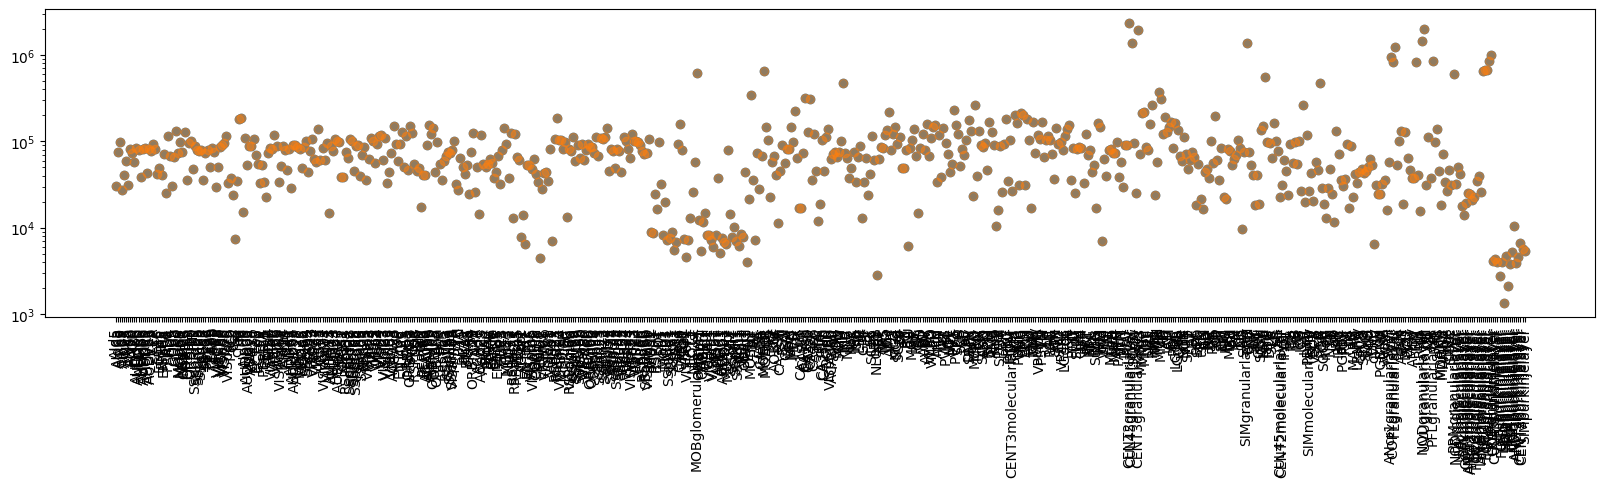

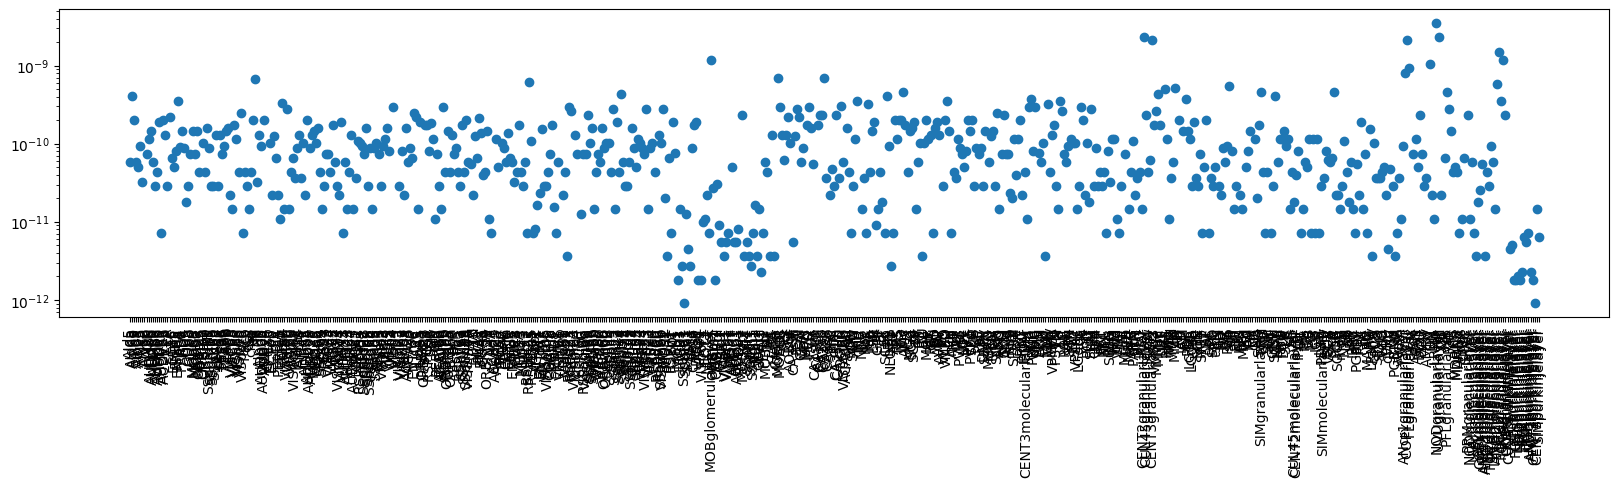

In [14]:
plt.figure(figsize=(20,4))
plt.semilogy(np.sum(t_densities_df.reindex(common_brain_regions)[common_ttypes].fillna(0), axis=1), 'o')
plt.semilogy(np.sum(me_types_densities.reindex(common_brain_regions).fillna(0), axis=1), 'o', alpha=.5)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(20,4))
plt.semilogy(np.abs(
    np.sum(t_densities_df.reindex(common_brain_regions)[common_ttypes].fillna(0), axis=1) - np.sum(me_types_densities.reindex(common_brain_regions).fillna(0), axis=1)
), 
             'o')
plt.xticks(rotation=90)
plt.show()

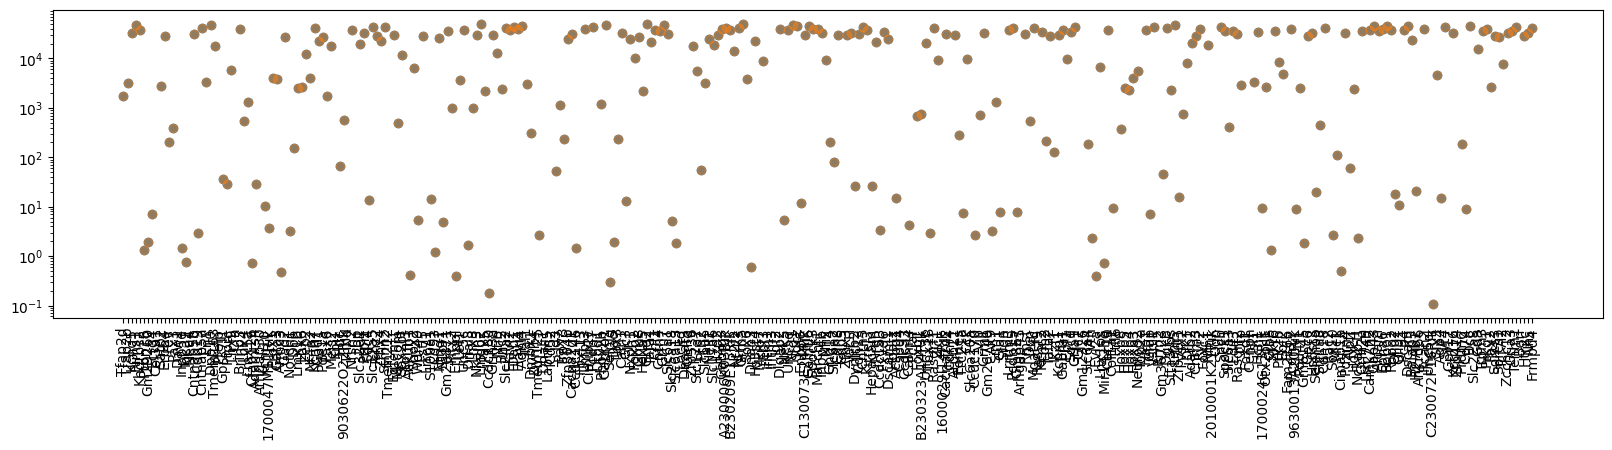

In [15]:
plt.figure(figsize=(20,4))
plt.semilogy(np.sum(ttype_gene_expression, axis=0), 'o')
plt.semilogy(np.sum(me_type_gene_expression, axis=0), 'o', alpha=.5)
plt.xticks(rotation=90)
plt.show()

In [16]:
from sklearn.preprocessing import StandardScaler
# ish_pred = StandardScaler().fit_transform(ish_pred)
# ish_true = StandardScaler().fit_transform(ish_true)

# err = np.abs(ish_pred - ish_true) / np.abs(ish_true)
# err_sum = np.abs(ish_pred_sum - ish_true) / np.abs(ish_true)
err_me = np.abs(ish_me - ish_true + 1e-1) / np.abs(ish_true  + 1e-1)

err_me

gene_identifier,Tfap2d,Tfap2b,Kcnq5,Rims1,Khdrbs2,Ptpn18,Gm29260,Ecrg4,Col3a1,Satb2,...,Sorcs3,Sorcs1,Tcf7l2,Zcchc12,Gria3,Tenm1,Bgn,Htr2c,Nhs,Frmpd4
AId5,6.924617,67935.830232,0.594812,0.496228,0.467807,10.642672,16.954218,157.353751,1.0,0.871898,...,0.497189,0.597081,184299.987992,3.019714,0.567888,0.451414,1.0,0.241589,1.502633,0.533491
AId6a,0.231878,156465.247739,0.553125,0.507155,0.470605,14.973140,26.822718,358.249369,1.0,0.856559,...,0.401074,0.516042,422420.215286,5.537511,0.561522,0.480871,1.0,1.681722,0.792391,0.562631
AId6b,0.206208,199240.983915,0.582729,0.517647,0.411021,18.681904,35.976326,451.799683,1.0,0.872820,...,0.605806,0.306149,533352.639149,3.408259,0.551885,0.476991,1.0,0.512996,0.116496,0.562001
AIp5,4.864486,55874.217013,0.574833,0.502478,0.262668,8.306929,11.888978,128.904718,1.0,0.751968,...,0.487702,0.485430,154930.275653,0.059829,0.555065,0.472262,1.0,0.381583,0.676752,0.465076
AIp6a,0.758046,93174.665289,0.538822,0.505554,0.409618,14.381361,21.959633,210.888739,1.0,0.881505,...,0.590174,0.120773,245586.657383,0.170626,0.552648,0.502589,1.0,0.084232,0.108767,0.558126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ANcr1purkinjelayer,3923.774750,7619.748541,65486.665899,0.550255,0.786370,4.567985,4.356450,18.426491,1.0,2414.745115,...,59566.733313,0.885693,0.669894,69772.532704,0.825975,1.683153,1.0,62459.568756,72834.758815,0.832790
ANcr2purkinjelayer,4446.934507,8644.600000,74362.887941,0.558023,0.791541,5.053457,4.829404,20.682087,1.0,2765.923387,...,67646.634477,1.023056,0.646079,79157.602654,0.829526,1.758453,1.0,70902.518932,82682.387902,0.836679
CENT2purkinjelayer,6589.578812,12806.448653,110138.728275,0.553618,0.789454,7.002796,6.663988,30.197113,1.0,4085.793668,...,100188.628838,0.585831,0.722525,117271.265144,0.828469,1.688485,1.0,105023.457496,122471.373291,0.835635
CENT3purkinjelayer,5473.722977,10638.347905,91496.256924,0.554200,0.789797,5.986871,5.706619,25.247099,1.0,3396.176339,...,83230.817592,0.607618,0.718721,97416.113646,0.828684,1.695335,1.0,87245.105263,101739.576960,0.835864


In [17]:
me_types_used = extended_p_me_t.columns[extended_p_me_t.T[comon_yaotypes].fillna(0).sum(axis=1) > 0]

(len(comon_yaotypes) / len(me_types_used))**2

127.32510821685324

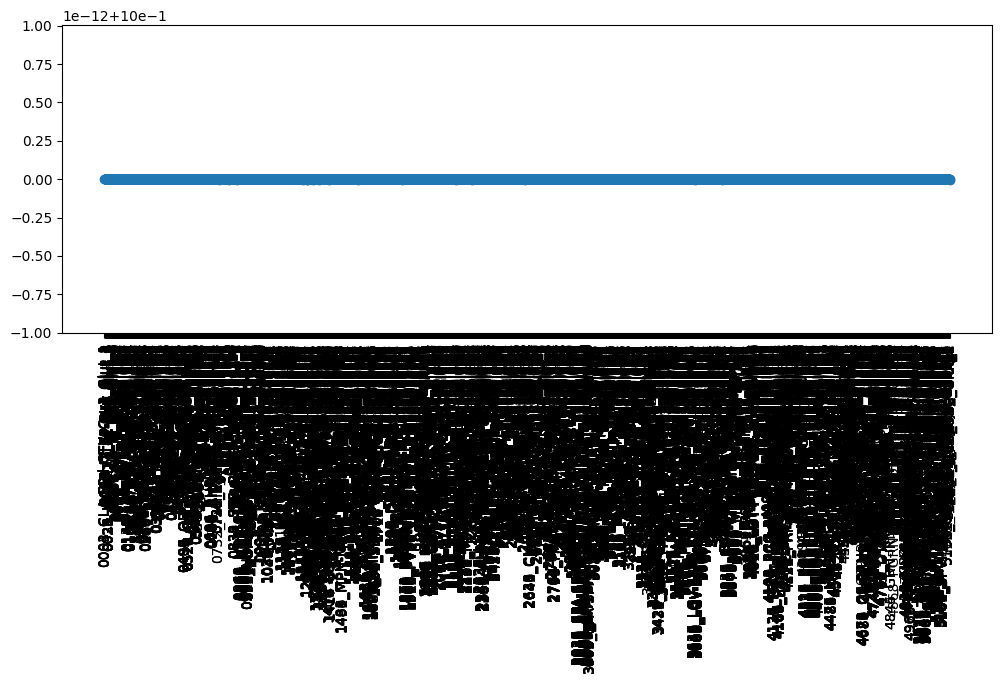

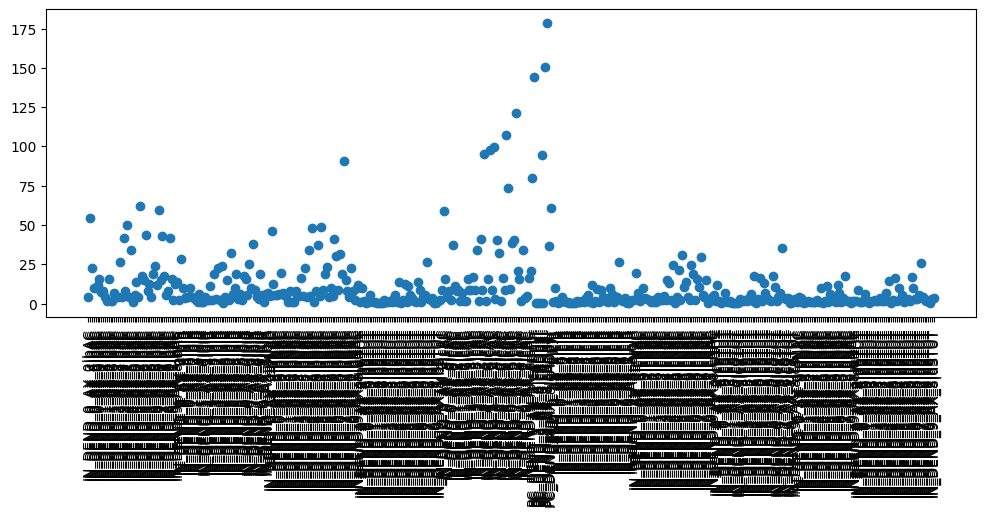

In [18]:
plt.figure(figsize=(12,4))
plt.plot(extended_p_me_t.T[comon_yaotypes].fillna(0).sum(), 'o')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(extended_p_me_t.T[comon_yaotypes].fillna(0).sum(axis=1), 'o')
plt.xticks(rotation=90)
plt.show()


In [19]:
showed_brain_regions

NameError: name 'showed_brain_regions' is not defined

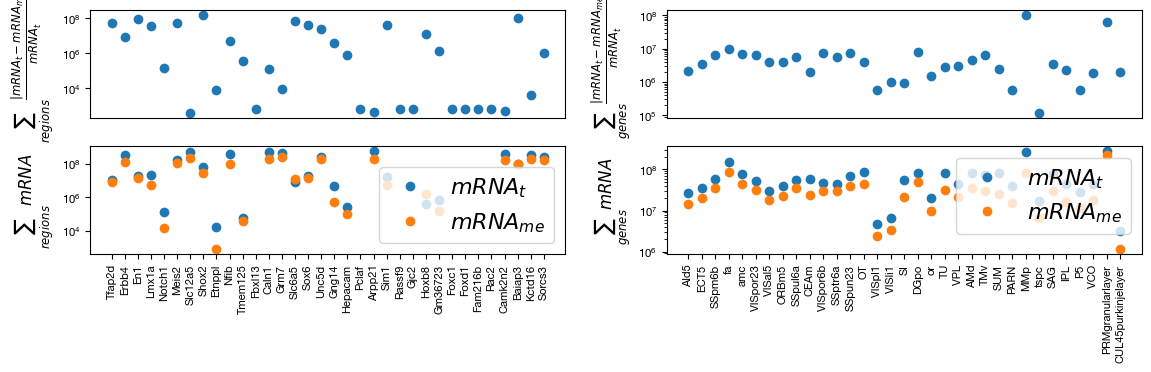

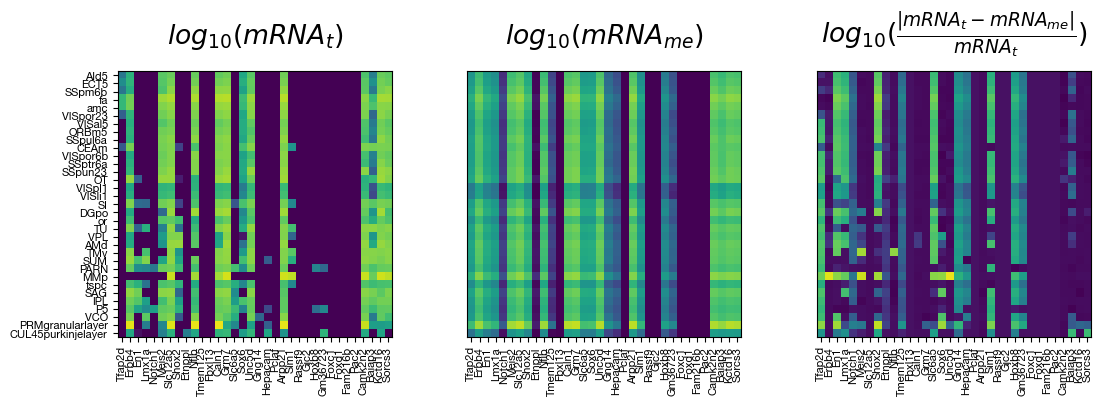

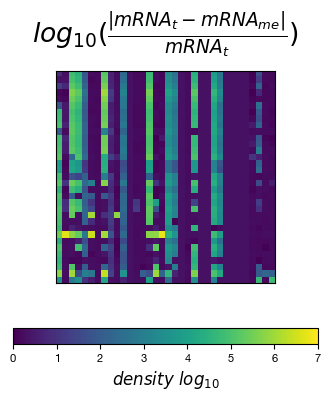

In [21]:
# Defining the global font properties
plt.rcParams.update({
    'font.size': 16,            # Default font size for text
    'font.family': 'Helvetica Neue',      # Font family (e.g., 'serif', 'sans-serif')
    'axes.titleweight': 'bold',  # Title font weight (e.g., 'bold', 'normal')
    'axes.labelsize': 12,        # Font size for axis labels
    'xtick.labelsize': 8,       # Font size for x-tick labels
    'ytick.labelsize': 8,       # Font size for y-tick labels
    'figure.titlesize': 16,      # Font size for figure title
    'figure.titleweight': 'bold',# Font weight for figure title
    'axes.titlepad': 20,         # Padding between title and plot
    'figure.figsize': (10, 6),   # Default figure size (width, height)
    'axes.titlelocation': 'center'  # Center-align the title
})

showed_brain_regions = common_brain_regions[::20].drop('y')
showed_genes = ish_true.columns[::10]

plt.figure(figsize=(11.8,4))

plt.subplot(221)
plt.semilogy(err_me.sum()[showed_genes], 'o')
plt.xticks([], [], rotation=90)
plt.ylabel(r'$\sum_{regions}^{} \frac{|mRNA_{t} - mRNA_{me}|}{mRNA_{t}}$')

plt.subplot(222)
plt.semilogy(err_me.T.sum()[showed_brain_regions], 'o')
plt.xticks([], [], rotation=90)
plt.ylabel(r'$\sum_{genes}^{} \frac{|mRNA_{t} - mRNA_{me}|}{mRNA_{t}}$')

plt.subplot(223)
plt.semilogy(ish_true.sum()[showed_genes], 'o')
plt.semilogy((ish_me).sum()[showed_genes], 'o') #/70
plt.ylabel(r'$\sum_{regions}^{} mRNA$')
plt.xticks(rotation=90)
plt.legend([r'$mRNA_{t}$', r'$mRNA_{me}$'])

plt.subplot(224)
plt.semilogy(ish_true.T.sum()[showed_brain_regions], 'o')
plt.semilogy(ish_me.T.sum()[showed_brain_regions], 'o') #/70
plt.ylabel(r'$\sum_{genes}^{} mRNA$')
plt.xticks(rotation=90)
plt.legend([r'$mRNA_{t}$', r'$mRNA_{me}$'])

plt.tight_layout()
plt.show()


plt.figure(figsize=(11.8,11.8/3))

plt.subplot(131)
plt.imshow(np.log10(ish_true.reindex(showed_brain_regions)[showed_genes] + 1), vmin=0, vmax=7)
plt.title(r'$log_{10}(mRNA_{t})$')
plt.xticks(np.arange(len(showed_genes)), showed_genes, rotation=90)
plt.yticks(np.arange(len(showed_brain_regions)), showed_brain_regions)
# plt.colorbar()

plt.subplot(132)
plt.imshow(np.log10(ish_me.reindex(showed_brain_regions)[showed_genes] + 1), vmin=0, vmax=7)
plt.title(r'$log_{10}(mRNA_{me})$')
plt.xticks(np.arange(len(showed_genes)), showed_genes, rotation=90)
plt.yticks(np.arange(len(showed_brain_regions)), showed_brain_regions)
plt.yticks([], [])
# plt.colorbar()

plt.subplot(133)
plt.imshow(np.log10(err_me.reindex(showed_brain_regions)[showed_genes] + 1), vmin=0, vmax=7)
plt.title(r'$log_{10}(\frac{|mRNA_{t} - mRNA_{me}|}{mRNA_{t}})$')
plt.xticks(np.arange(len(showed_genes)), showed_genes, rotation=90)
plt.yticks(np.arange(len(showed_brain_regions)), showed_brain_regions)
plt.yticks([], [])
# plt.colorbar()

plt.tight_layout()
plt.show()

plt.figure(figsize=(11.8/3,11.8/3))
plt.imshow(np.log10(err_me.reindex(showed_brain_regions)[showed_genes] + 1), vmin=0, vmax=7)
plt.title(r'$log_{10}(\frac{|mRNA_{t} - mRNA_{me}|}{mRNA_{t}})$')
plt.xticks(np.arange(len(showed_genes)), showed_genes, rotation=90)
plt.xticks([], [])
plt.yticks(np.arange(len(showed_brain_regions)), showed_brain_regions)
plt.yticks([], [])
plt.colorbar(label=r'$density \ log_{10}$', location='bottom', orientation='horizontal')
plt.show()

In [22]:
print(
ish_true.sum().sum(),
(ish_me).sum().sum(),
    (ish_true.sum().sum() - (ish_me).sum().sum() )/ ish_true.sum().sum()
)

51560433206.63605 26893810360.24195 0.47840216445697736


In [23]:
ish_true

gene_identifier,Tfap2d,Tfap2b,Kcnq5,Rims1,Khdrbs2,Ptpn18,Gm29260,Ecrg4,Col3a1,Satb2,...,Sorcs3,Sorcs1,Tcf7l2,Zcchc12,Gria3,Tenm1,Bgn,Htr2c,Nhs,Frmpd4
AId5,555.036594,0.0,278600.277611,288476.603021,219259.045329,0.0,0.0,0.0,0.0,209785.540642,...,180192.330008,201195.222749,0.000000,18906.045170,277510.609752,228181.016052,0.0,59759.282937,29752.361185,273105.091700
AId6a,8527.159752,0.0,650010.097878,741027.391182,553130.291799,0.0,0.0,0.0,0.0,542810.753746,...,381394.506244,415576.021768,0.000000,27220.418214,696571.655796,597851.195065,0.0,66580.982064,96353.525262,737632.598416
AId6b,16757.116443,0.0,871058.523581,948829.907740,623217.716707,0.0,0.0,0.0,0.0,757154.630617,...,726669.171573,363930.172526,0.000000,50924.797674,853048.685413,744573.401240,0.0,148708.082552,195407.611972,922751.143990
AIp5,632.498474,0.0,237018.855955,257961.324790,139371.396598,0.0,0.0,0.0,0.0,103381.817507,...,156151.724843,137986.240138,0.000000,60982.431495,239492.847346,207969.977313,0.0,103120.481879,37512.000444,211058.530411
AIp6a,3409.249213,0.0,329080.889430,394317.882089,265695.471606,0.0,0.0,0.0,0.0,303866.900501,...,297320.568867,124007.558574,0.000000,87275.855156,360024.623334,337732.447405,0.0,92406.888536,90338.245180,387020.902987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ANcr1purkinjelayer,0.000000,0.0,0.000000,21466.255531,36950.920413,0.0,0.0,0.0,0.0,0.000000,...,0.000000,3014.023483,4883.104921,0.000000,42363.666869,3288.723727,0.0,0.000000,0.000000,48766.771646
ANcr2purkinjelayer,0.000000,0.0,0.000000,24808.206192,42990.529116,0.0,0.0,0.0,0.0,0.000000,...,0.000000,3189.541421,5167.466511,0.000000,49129.144846,3631.966562,0.0,0.000000,0.000000,56724.888082
CENT2purkinjelayer,0.000000,0.0,0.000000,36379.157897,63045.959930,0.0,0.0,0.0,0.0,0.000000,...,0.000000,6026.865748,9764.296118,0.000000,72307.294891,5519.593250,0.0,0.000000,0.000000,83468.514731
CENT3purkinjelayer,0.000000,0.0,0.000000,30261.245959,52459.286142,0.0,0.0,0.0,0.0,0.000000,...,0.000000,4938.821072,8001.524082,0.000000,60145.446400,4573.617030,0.0,0.000000,0.000000,69439.603928


In [24]:
ish_me/26.5

gene_identifier,Tfap2d,Tfap2b,Kcnq5,Rims1,Khdrbs2,Ptpn18,Gm29260,Ecrg4,Col3a1,Satb2,...,Sorcs3,Sorcs1,Tcf7l2,Zcchc12,Gria3,Tenm1,Bgn,Htr2c,Nhs,Frmpd4
AId5,166.001691,256.357850,4259.822623,5484.009776,4403.321427,0.036387,0.060205,0.590014,0.0,1014.106982,...,3418.965473,3059.067262,695.467879,2867.814864,4525.114072,4723.651737,0.0,2799.862835,2809.784729,4807.767482
AId6a,396.390311,590.431124,10961.247839,13781.566312,11049.963656,0.052729,0.097444,1.348111,0.0,2938.156006,...,8619.882205,7589.476827,1594.034775,6715.253745,11525.697143,11711.766235,0.0,6737.800961,6517.101553,12174.234918
AId6b,501.945347,751.848996,13715.736757,17270.589973,13851.398404,0.066724,0.131986,1.701131,0.0,3633.777342,...,10809.372328,9528.800355,2012.647695,8471.318779,14425.055586,14695.023528,0.0,8490.363314,8232.897787,15251.476296
AIp5,139.987360,210.842328,3802.734354,4843.063819,3877.841981,0.027573,0.041090,0.482659,0.0,967.616589,...,3018.719046,2679.372734,584.638776,2438.900537,4021.082189,4141.640191,0.0,2406.466769,2373.519986,4260.385701
AIp6a,226.173296,351.598737,5726.966947,7357.304202,5919.310890,0.050496,0.079093,0.792033,0.0,1358.736517,...,4598.098996,4114.365732,926.738330,3855.371475,6077.650509,6339.303237,0.0,3780.771183,3779.773780,6453.368198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ANcr1purkinjelayer,14.802924,28.749994,247.115720,364.308668,297.873665,0.013464,0.012666,0.065760,0.0,9.108472,...,224.776352,214.472164,60.821774,263.288803,278.194922,332.989350,0.0,235.692712,274.844373,307.702904
ANcr2purkinjelayer,16.777111,32.617358,280.610898,413.755171,338.172731,0.015296,0.014451,0.074272,0.0,10.433673,...,255.266545,243.495216,69.008017,298.704161,316.040317,378.063577,0.0,267.552902,312.005237,349.591506
CENT2purkinjelayer,24.862562,48.322448,415.614069,612.786009,500.901945,0.022652,0.021374,0.110178,0.0,15.414316,...,378.066524,360.662323,102.233002,442.529302,468.029440,559.977810,0.0,396.311160,462.152352,517.703483
CENT3purkinjelayer,20.651785,40.140935,345.265120,509.067707,416.111048,0.018818,0.017761,0.091498,0.0,12.811986,...,314.074783,299.611236,84.924201,367.604202,388.818691,465.188586,0.0,329.223039,383.919158,430.087911


In [25]:
import matplotlib.pyplot as plt

def plot_map(data, title, filename):
    """Plot and save heatmap of data."""
    plt.figure(figsize=(5, 3))
    heatmap = plt.pcolor(data.values, cmap="jet")

    # for y in range(data.shape[0]):
    #     for x in range(data.shape[1]):
    #         if 0 < data.values[y, x] < 1.:
    #             plt.text(x + 0.5, y + 0.5, int(100 * data.values[y, x]),
    #                      horizontalalignment='center',
    #                      verticalalignment='center')

    plt.colorbar(heatmap, label =r"$log_{10}(mm^{3})$")
    plt.xticks(np.arange(len(data.columns)) + .5, data.columns, rotation=90)
    plt.yticks(np.arange(len(data.index)) + .5, data.index)
    plt.title(title)
    # plt.tight_layout()
    plt.savefig(filename)

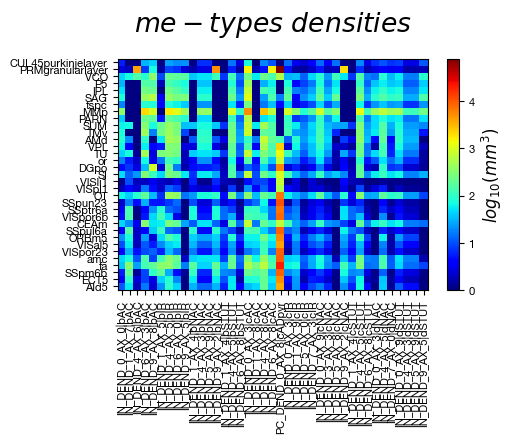

In [26]:
# showed_brain_regions_heatmap = common_brain_regions[::20].drop('y')
me_types_used_heatmap = me_types_used[::12]
plot_map(np.log10(me_types_densities.reindex(showed_brain_regions)[me_types_used_heatmap] + 1.), 
         r"$me-types \ densities$", 
         "me_types_densities_.png")
plt.show()

In [27]:
import pandas as pd
import umap
import matplotlib.pyplot as plt

def plot_umap(df, types, showed_reg):
    """
    Plot a UMAP of the dataset and print the sample names next to the datapoints.
    
    Parameters:
    df (pd.DataFrame): Input dataframe with sample names as the index and feature values as the values.
    """
    # Initialize UMAP model
    reducer = umap.UMAP()
    
    # Fit and transform the data
    embedding = reducer.fit_transform(df.values)
    
    # Create a scatter plot
    plt.figure(figsize=(5, 5))
    plt.scatter(embedding[:, 0], embedding[:, 1], s=100, alpha=0.5)
    
    # Annotate points with sample names
    for i, sample_name in enumerate(df.index):
        if sample_name in showed_reg:
            plt.annotate(sample_name, (embedding[i, 0], embedding[i, 1]), fontsize=9, alpha=0.75)
    
    # Set plot title and labels
    plt.title(f'UMAP of the {types} compositon')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    
    # Show the plot
    plt.show()

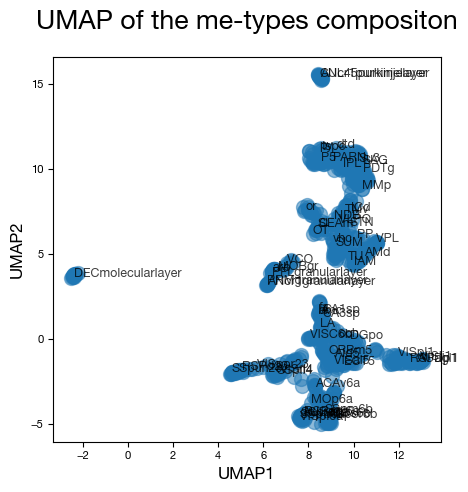

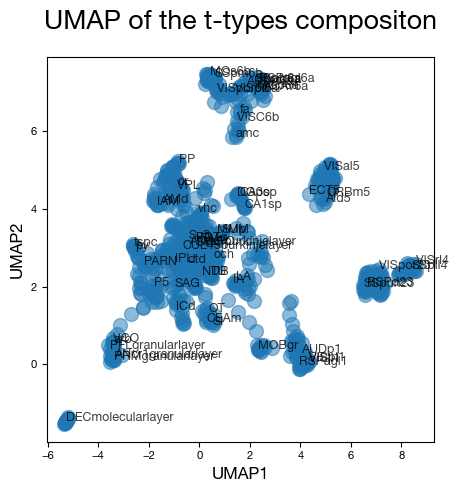

In [28]:
showed_brain_regions_umap = common_brain_regions[::10].drop('y')
plot_umap(np.log10(me_types_densities + 1), "me-types", showed_brain_regions_umap)
plot_umap(np.log10(t_densities_df[common_ttypes].fillna(0) + 1), "t-types", showed_brain_regions_umap)

In [29]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns

def plot_umap_and_clusters(df, types, showed_reg, max_clusters=10):
    """
    Plot a UMAP projection and perform clustering.
    Use the Elbow Method to determine the optimal number of clusters.
    Plot a dendrogram and a bar plot of e-type distribution within clusters.
    
    Parameters:
    df (pd.DataFrame): Input dataframe with sample names as the index and feature values as the values.
    max_clusters (int): Maximum number of clusters to test for the Elbow Method.
    """
    # Initialize UMAP model
    reducer = umap.UMAP()
    
    # Fit and transform the data
    embedding = reducer.fit_transform(df.values)
    
    # Determine the optimal number of clusters using the Elbow Method
    wcss = []
    for n in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n, random_state=42)
        # kmeans.fit(embedding)
        kmeans.fit_predict(df.values)
        wcss.append(kmeans.inertia_)
    
    # Plot the Elbow Method graph
    plt.figure(figsize=(5, 2.5))
    plt.plot(range(1, max_clusters + 1), wcss, marker='o')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
    # Ask the user to input the optimal number of clusters based on the Elbow plot
    optimal_clusters = int(input("Enter the optimal number of clusters based on the Elbow plot: "))
    
    # Perform K-Means clustering with the selected number of clusters
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(embedding)
    # df['cluster'] = kmeans.fit_predict(df.values)
    df['cluster'] = ['cluster_' + str(x) for x in df['cluster']]
    
    # Plot UMAP projection with cluster labels
    plt.figure(figsize=(11.8 / 3, 4))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], 
                          c=[int(x.split("_")[1]) for x in df['cluster']], 
                          cmap='viridis', s=100, alpha=0.5)
    # plt.title('UMAP projection with K-Means clusters')
    plt.title(f'{types} compositon UMAP')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend(*scatter.legend_elements(), title="Clusters", fontsize=8)
    
    # Annotate points with sample names
    for i, sample_name in enumerate(df.index):
        if sample_name in showed_reg:
            plt.annotate(sample_name, (embedding[i, 0], embedding[i, 1]), fontsize=9, alpha=0.75)
    plt.show()

    # try:
    #     # Hierarchical Clustering and Dendrogram
    #     Z = linkage(df.drop('cluster', axis=1), method='ward')
    #     plt.figure(figsize=(30, 8))
    #     dendrogram(Z, labels=df.index, leaf_rotation=90, leaf_font_size=8, color_threshold=0)
    #     plt.title('Hierarchical Clustering Dendrogram')
    #     plt.xlabel('Sample Index')
    #     plt.ylabel('Distance')
    #     plt.show()
    # except:
    #     print("HCA error")
    # try:
    #     # Bar plot of e-type distribution within clusters
    #     cluster_counts = df.groupby('cluster').size()
    #     type_distribution = df.groupby(['cluster'])[df.columns[:-1]].sum()
    #     # e_type_distribution_percent = e_type_distribution.div(cluster_counts, axis=0) * 100
    #     type_distribution_percent = type_distribution.div(np.sum(type_distribution, axis=1), axis=0) * 100

    
    #     type_distribution_percent.plot(kind='bar', stacked=True, figsize=(5, 5), colormap='jet')
    #     plt.title('Type Distribution within Clusters')
    #     plt.xlabel('Cluster')
    #     plt.ylabel('Percentage')
    #     # plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    #     plt.show()
    # except:
    #     print("bar plot error")

    return df


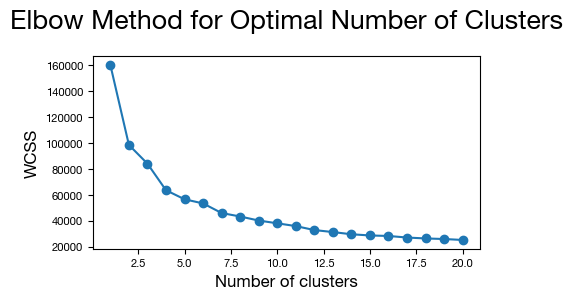

Enter the optimal number of clusters based on the Elbow plot:  6


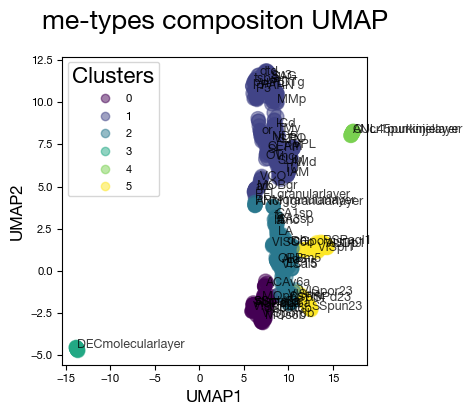

In [30]:
showed_brain_regions_umap = common_brain_regions[::10].drop('y')
me_types_densities_clusters = plot_umap_and_clusters(np.log10(me_types_densities + 1.), 
                                                     "me-types", 
                                                     showed_brain_regions_umap, 
                                                     max_clusters=20)

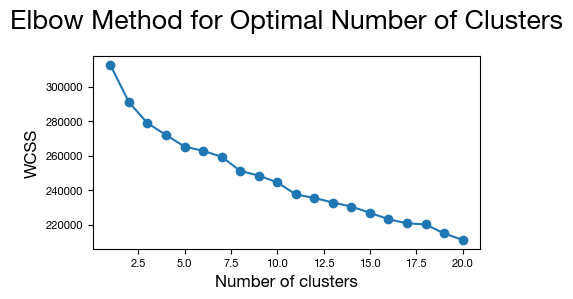

Enter the optimal number of clusters based on the Elbow plot:  8


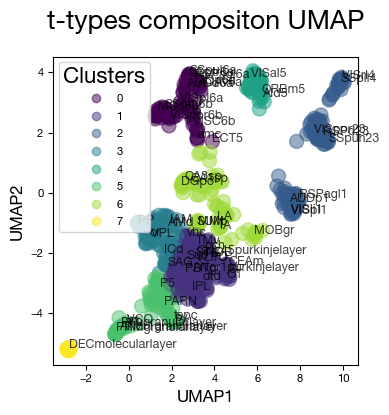

In [31]:
t_types_densities_clusters = plot_umap_and_clusters(np.log10(t_densities_df[common_ttypes].fillna(0) + 1), 
                                                     "t-types", 
                                                     showed_brain_regions_umap, 
                                                     max_clusters=20)

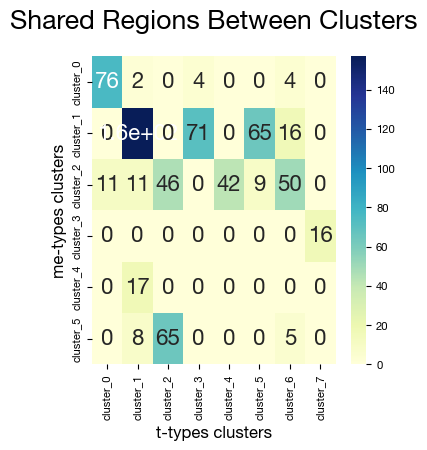

In [32]:
import seaborn as sns

# Merge the two dataframes on index and keep only the cluster columns
df_merged = pd.DataFrame({'cluster_t': t_types_densities_clusters['cluster'], 'cluster_me': me_types_densities_clusters['cluster']})

# Create the contingency table using `pd.crosstab`
contingency_table = pd.crosstab(df_merged['cluster_me'], df_merged['cluster_t'])

# Plot the contingency table as a heatmap
plt.figure(figsize=(11.8 / 3, 4))
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu", cbar=True)
plt.xlabel("t-types clusters")
plt.ylabel("me-types clusters")
plt.title("Shared Regions Between Clusters")
plt.show()

In [36]:
def get_example_indices(df_me):
    # Group by the cluster column and get the first index from each cluster
    example_indices = df_me.groupby('cluster').apply(lambda x: x.index[0])
    return example_indices
    
def create_pie_charts(df, df_c, example_indices, threshold=1):
    # Determine the layout of subplots based on the number of clusters
    n_clusters = len(example_indices)
    n_cols = 3  # Define how many columns per row
    n_rows = (n_clusters + n_cols - 1) // n_cols  # Calculate rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(11.8, (11.8 / n_cols) * n_rows))
    axes = axes.flatten()  # Flatten to make indexing easier

    # Loop over each region and create a pie chart in a subplot
    for i, reg in enumerate(example_indices):
        data = df.T[reg].T
        values = data / data.sum()  # Normalize to get percentages
        labels = data.index
        
        # Filter out labels with less than threshold percentage
        filtered_labels = [label if pct > threshold  else '' for label, pct in zip(labels, values * 100)]
        filtered_pct = [f'{pct:.1f}%' if pct > threshold else '' for pct in values * 100]
        
        # Plot pie chart in the corresponding subplot
        axes[i].pie(values, labels=filtered_labels, autopct=lambda pct: f'{pct:.1f}%' if pct > threshold else '', startangle=140)
        axes[i].set_title(f'{reg} ({df_c["cluster"][reg]})')

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # plt.tight_layout()
    plt.show()

In [50]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def get_example_indices(df_me):
    # Group by the cluster column and get the first index from each cluster
    example_indices = df_me.groupby('cluster').apply(lambda x: x.index[0])
    return example_indices

def create_pie_charts(df, df_c, example_indices, threshold=1):
    # Determine the layout of subplots based on the number of clusters
    n_clusters = len(example_indices)
    n_cols = 3  # Define how many columns per row
    n_rows = (n_clusters + n_cols - 1) // n_cols  # Calculate rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(11.8, (11.8 / n_cols) * n_rows))
    axes = axes.flatten()  # Flatten to make indexing easier

    # Define a perceptually uniform colormap
    cmap = colormaps["jet"]
    colors = cmap(np.linspace(0, 1, len(df.index)))  # Generate distinct colors for all labels

    # Loop over each region and create a pie chart in a subplot
    for i, reg in enumerate(example_indices):
        data = df.T[reg].T
        values = data / data.sum()  # Normalize to get percentages
        labels = data.index

        # Filter out labels with less than threshold percentage
        filtered_labels = [label if pct > threshold else '' for label, pct in zip(labels, values * 100)]
        filtered_pct = [f'{pct:.1f}%' if pct > threshold else '' for pct in values * 100]

        # Select corresponding colors
        chart_colors = [colors[j] for j in range(len(labels))]

        # Plot pie chart in the corresponding subplot
        axes[i].pie(
            values,
            labels=filtered_labels,
            autopct=lambda pct: f'{pct:.1f}%' if pct > threshold else '',
            startangle=140,
            colors=chart_colors
        )
        axes[i].set_title(f"{reg} ({df_c['cluster'][reg]})")

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [57]:
showed_brain_regions

Index(['AId5', 'ECT5', 'SSpm6b', 'fa', 'amc', 'VISpor23', 'VISal5', 'ORBm5',
       'SSpul6a', 'CEAm', 'VISpor6b', 'SSptr6a', 'SSpun23', 'OT', 'VISpl1',
       'VISli1', 'SI', 'DGpo', 'or', 'TU', 'VPL', 'AMd', 'TMv', 'SUM', 'PARN',
       'MMp', 'tspc', 'SAG', 'IPL', 'P5', 'VCO', 'PRMgranularlayer',
       'CUL45purkinjelayer'],
      dtype='object')

In [56]:
example_indices

cluster
cluster_0                SSpm6b
cluster_1                  CEAm
cluster_2                  AId5
cluster_4    CUL45purkinjelayer
cluster_5              VISpor23
dtype: object

/var/folders/mt/7f938cq120v6pjmztk2lb650l8xs4d/T/ipykernel_20565/3078703082.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  example_indices = df_me.groupby('cluster').apply(lambda x: x.index[0])


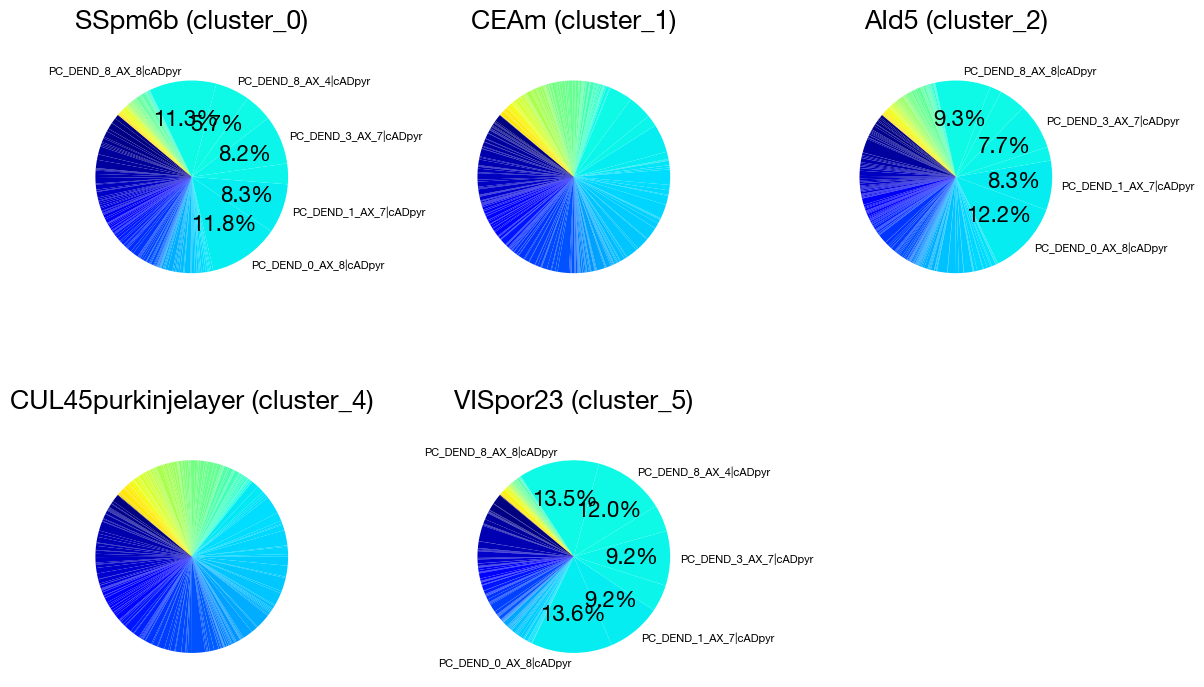

In [55]:
from matplotlib import colormaps

cmap = colormaps["jet"]

example_indices = get_example_indices(me_types_densities_clusters.reindex(showed_brain_regions))
create_pie_charts(me_types_densities, me_types_densities_clusters, example_indices, threshold=4.9)

/var/folders/mt/7f938cq120v6pjmztk2lb650l8xs4d/T/ipykernel_20565/3078703082.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  example_indices = df_me.groupby('cluster').apply(lambda x: x.index[0])


IndexError: index 703 is out of bounds for axis 0 with size 703

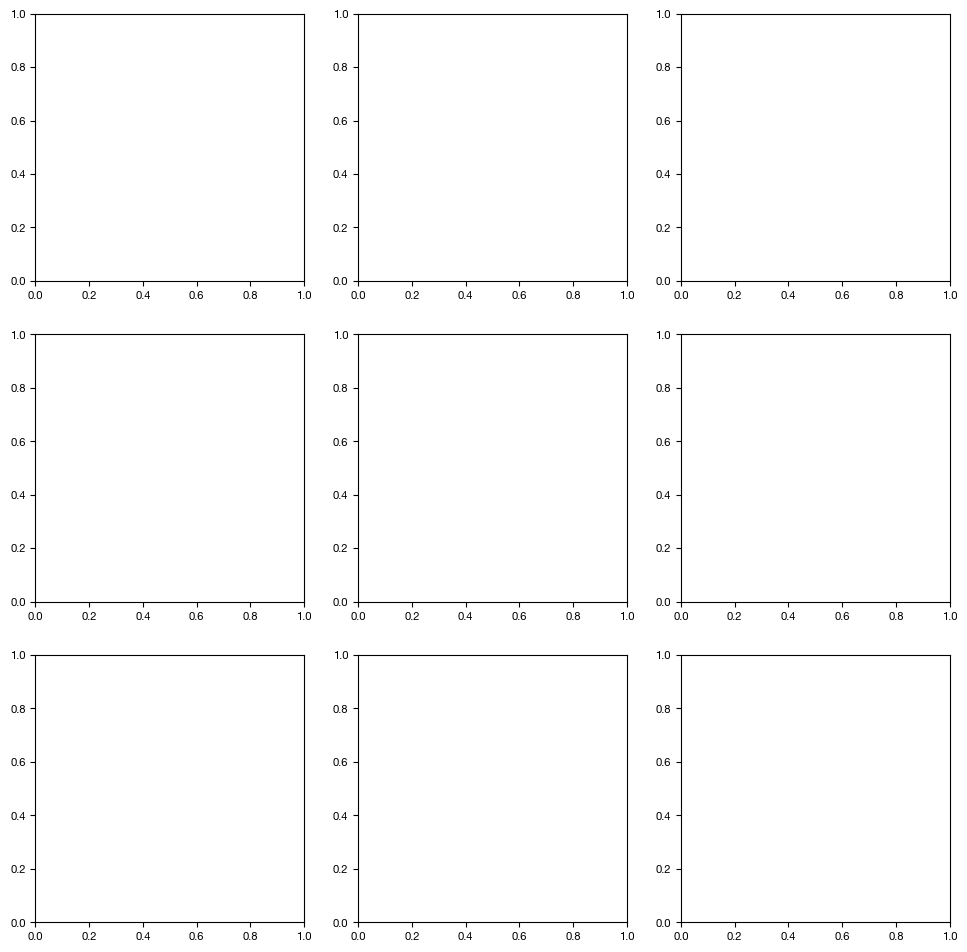

In [52]:
example_indices = get_example_indices(t_types_densities_clusters.reindex(showed_brain_regions))
create_pie_charts(t_densities_df[common_ttypes].fillna(0), t_types_densities_clusters, example_indices, threshold=4.9)